### MAST30034: Applied Data Science Project 1
---
# Data Analysis: FHVHV Dataset
#### Xavier Travers (1178369)

Performs data analysis to relate the COVID dataset and FHVHV aggregate dataset

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame, Column, Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

# add homemade helpers
sys.path.insert(1, '../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/09 22:31:22 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.20.85.51 instead (on interface eth0)
22/08/09 22:31:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/09 22:31:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/09 22:31:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/09 22:31:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/09 22:31:24 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
# read in the aggregated yellow tlc data
yellow_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/')
yellow_df.limit(5)

year,cdc_week,week_index,pu_borough,do_borough,passengers,num_*,tot_trip_distance,avg_trip_distance
2018,28,28,Manhattan,Staten Island,0.0,2,38.3,19.15
2018,29,29,Manhattan,EWR,4.0,113,2015.0299999999988,17.8321238938053
2018,30,30,Queens,Queens,6.0,914,5293.399999999994,5.791466083150978
2018,30,30,Manhattan,Brooklyn,0.0,283,1834.8999999999996,6.483745583038868
2018,31,31,Manhattan,Bronx,3.0,389,3279.1499999999996,8.42969151670951


In [4]:
# read in the aggregated covid data
flu_df = spark.read.parquet('../data/curated/virals/flu/cases-by-week/')
flu_df.limit(5)

year,month,day,week_index,cdc_week,date,borough,disease,cases
2018,1,20,3,3,01/20/2018,Bronx,INFLUENZA_B,203
2018,5,5,18,18,05/05/2018,Staten Island,INFLUENZA_UNSPECI...,0
2018,3,10,10,10,03/10/2018,Manhattan,INFLUENZA_A,65
2018,3,3,9,9,03/03/2018,Brooklyn,INFLUENZA_B,287
2018,5,12,19,19,05/12/2018,Manhattan,INFLUENZA_B,10


In [5]:
flu_df = flu_df.groupBy('week_index', 'borough')\
    .agg(
        F.sum('cases').alias('tot_cases')
    )

In [6]:
# join the datasets by week_index
joined_df = jh.join_by_week_by_borough(yellow_df, flu_df, 'tot_cases')
joined_df.limit(5)

do_borough,prev_week_index,pu_borough,year,cdc_week,week_index,passengers,num_*,tot_trip_distance,avg_trip_distance,pu_tot_cases,do_tot_cases
Manhattan,52,Manhattan,2019,1,53,6.0,24761,45956.880000000165,1.8560187391462446,205.0,205.0
Manhattan,57,Manhattan,2019,6,58,5.0,68086,125829.96999999847,1.8481034280174848,450.0,450.0
Manhattan,42,Manhattan,2018,43,43,1.0,1212066,2220021.0499999616,1.831600795666211,8.0,8.0
Queens,46,Manhattan,2018,47,47,6.0,1388,14492.71999999999,10.441440922190194,13.0,17.0
Queens,40,Manhattan,2018,41,41,5.0,2738,29271.489999999994,10.690829072315557,6.0,7.0


In [7]:
# first, aggregate on number of passengers > 1
joined_df = joined_df\
    .where(F.col('passengers') >= 2)\
    .groupBy('week_index', 'do_borough')\
    .agg(
        F.sum('do_tot_cases').alias('do_tot_cases'),
        F.sum('num_*').alias('num_trips'),
        (F.sum('num_*') / 7).alias('avg_trips')
    )
joined_df.limit(5)

week_index,do_borough,do_tot_cases,num_trips,avg_trips
42,Queens,189.0,26960,3851.4285714285716
48,Brooklyn,660.0,21962,3137.4285714285716
42,Manhattan,130.0,486957,69565.28571428571
49,Brooklyn,1232.0,21657,3093.8571428571427
43,Bronx,105.0,3201,457.2857142857143


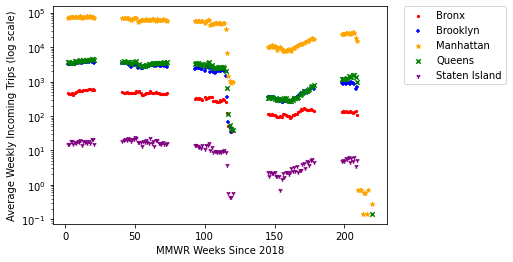

In [11]:
# plot a time-series histogram to show how average weekly trips changes per week
ph.group_plot(joined_df.toPandas(), 'week_index', 'avg_trips',
    'do_borough', filename_prefix = 'yellow-covid', kind = 'scatter',
    xlabel = 'MMWR Weeks Since 2018', 
    ylabel = 'Average Weekly Incoming Trips', logy=True)

In [9]:
borough_part = Window.partitionBy('do_borough')
joined_df.withColumn('min_avg_trips', F.min('avg_trips').over(borough_part))\
    .where(F.col('avg_trips') == F.col('min_avg_trips'))\
    .drop('min_avg_trips')

week_index,do_borough,do_tot_cases,num_trips,avg_trips
119,Bronx,266.0,245,35.0
119,Brooklyn,224.0,246,35.142857142857146
213,Manhattan,23.0,1,0.14285714285714285
216,Manhattan,75.0,1,0.14285714285714285
220,Queens,166.0,1,0.14285714285714285
118,Staten Island,27.0,3,0.42857142857142855
119,Staten Island,3.0,3,0.42857142857142855


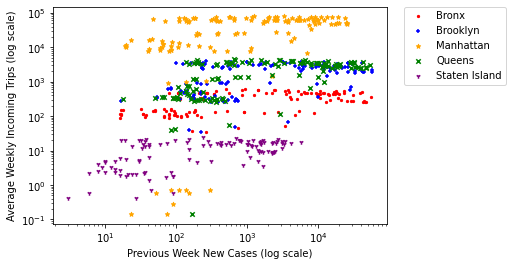

In [10]:
# plot a general/dirt scatter plot of avg wkly trips vs cases from prev wk
ph.group_plot(joined_df.toPandas(), 'do_tot_cases', 'avg_trips',
    'do_borough', filename_prefix = 'yellow-covid', 
    xlabel = 'Previous Week New Cases', 
    ylabel = 'Average Weekly Incoming Trips',
    logx=True, logy=True)

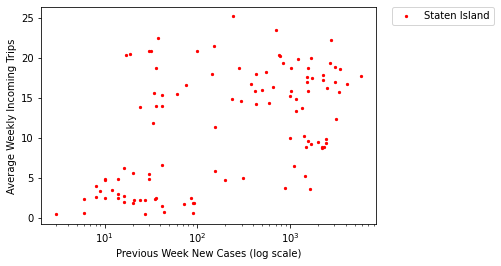

In [13]:
ph.group_plot(joined_df.where(F.col('do_borough') == 'Staten Island').toPandas(), 'do_tot_cases', 'avg_trips',
    'do_borough', filename_prefix = 'yellow-covid', 
    xlabel = 'Previous Week New Cases', 
    ylabel = 'Average Weekly Incoming Trips',
    logx=True, logy=False)